In [1]:
#!pip3 install -U -r requirements.txt

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from tqdm.notebook import trange, tqdm

# import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import plotly
plotly.offline.init_notebook_mode(connected=True)
import os
import shutup

In [2]:
from avalanche.benchmarks import SplitMNIST, SplitCIFAR10
import lovely_tensors as lt
from torchvision import transforms, datasets
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import shutup;
import pytorch_lightning as pl
import os 

import plotly
plotly.offline.init_notebook_mode(connected=True)

os.environ['PYTORCH_ENABLE_MPS_FALLBACK']="1"
os.chdir("../..")

shutup.please()
pl.seed_everything(42)
lt.monkey_patch()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Global seed set to 42


## Load Data

In [3]:
from avalanche.benchmarks import SplitCIFAR10

benchmark = SplitCIFAR10(
    n_experiences=1,
    return_task_id=True,
    shuffle=False,
    dataset_root='../datasets',
    train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
    eval_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
)

training_data = benchmark.train_stream[0].dataset
validation_data = benchmark.test_stream[0].dataset

Files already downloaded and verified
Files already downloaded and verified


In [4]:
data_variance = 0.06328692405746414

In [5]:
import wandb
import argparse
from train_utils import get_device, add_arguments, get_wandb_params
from src.vq_vae.init_scrips import get_model
from src.utils.train_script import overwrite_config_with_args, parse_arguments
from configparser import ConfigParser
from src.transformer_vq_vae.configuration.config import TrainConfig

ini_config = ConfigParser()
ini_config.read("./src/transformer_vq_vae/configuration/train.ini")

parser = argparse.ArgumentParser(description="Model trainer")
parser = add_arguments(parser)

## Read args
args = parse_arguments(parser)
args.accelerator = "gpu"
args.devices = "1,"
args.train_logger = "tensorboard"
args.evaluation_logger = "int"
args.max_epochs = 200
args.min_epochs = 60
args.max_epochs_igpt = 300
args.min_epochs_igpt = 30
args.num_workers = 0
args.regularization_dropout = 0.0
args.regularization_lambda = 0.0
args.learning_rate = 0.001
args.batch_size = 128
args.best_model_prefix = "artifacts"
args.num_random_noise = 0
args.model = "transformer-vq-vae"
args.embedding_dim = 192
args.num_embeddings = 128
args.use_lpips = True

config = TrainConfig.construct_typed_config(ini_config)
overwrite_config_with_args(args, config)

is_using_wandb = (
    config.train_logger == "wandb"
    or config.evaluation_logger == "wandb"
    or args.run_id
)
if is_using_wandb:
    wandb_params = get_wandb_params(args, config)

    wandb.run.name = args.experiment_name or (
        f"RI-0."
        f"RN-{config.num_random_noise}."
        f"Dr-{config.regularization_dropout}."
        f"Wd-{config.regularization_lambda}."
    )
    wandb_params["name"] = wandb.run.name
else:
    wandb_params = None

In [6]:
from avalanche.training.plugins import EvaluationPlugin
from train_utils import get_loggers
from src.avalanche.strategies import NaivePytorchLightning
from src.transformer_vq_vae.model.vit_vq_vae import VitVQVae


device = get_device(config)
vq_vae_model = VitVQVae(
    num_embeddings=config.num_embeddings,
    embedding_dim=config.embedding_dim,
    commitment_cost=config.commitment_cost,
    decay=config.decay,
    learning_rate=(
        config.learning_rate
        * config.batch_size
        * config.accumulate_grad_batches
        / 256
    ),
    weight_decay=config.weight_decay,
    mask_ratio=config.mask_ratio,
)
vq_vae_model.load_state_dict(
    torch.load('/scratch/shared/beegfs/dzverev/artifacts/model/7oj4nxyh/model/model-exp-0-ep-1320.ckpt')['state_dict']
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /users/dzverev/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528M/528M [00:04<00:00, 117MB/s]


Loading model from: /users/dzverev/.conda/envs/cl/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


<All keys matched successfully>

In [7]:
from src.vq_vae.init_scrips import get_callbacks


train_experience, test_experience = next(iter(zip(benchmark.train_stream, benchmark.test_stream)))
# Test trained model
cl_strategy_logger, eval_plugin_loggers = get_loggers(config, vq_vae_model, wandb_params)
evaluation_plugin = EvaluationPlugin()

cl_strategy = NaivePytorchLightning(
    accelerator=config.accelerator,
    devices=config.devices,
    validate_every_n=config.validate_every_n,
    accumulate_grad_batches=config.accumulate_grad_batches,
    train_logger=cl_strategy_logger,
    initial_resume_from=args.resume_from,
    model=vq_vae_model,
    device=device,
    optimizer=vq_vae_model.configure_optimizers(),
    criterion=vq_vae_model.criterion,
    train_mb_size=config.batch_size,
    train_mb_num_workers=config.num_workers,
    train_epochs=config.max_epochs,
    eval_mb_size=config.batch_size,
    evaluator=evaluation_plugin,
    callbacks=get_callbacks(config),
    max_epochs=config.max_epochs,
    min_epochs=config.min_epochs,
    best_model_path_prefix=config.best_model_prefix,
    plugins=[],
)

Adjusting learning rate of group 0 to 2.5000e-06.


In [8]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np 
from torchvision.utils import make_grid
from einops import repeat, rearrange
from src.transformer_vq_vae.model.encoder import PatchShuffle

vq_vae_model.eval()
vq_vae_model.to(device)


test_dataset = train_experience.dataset
validation_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
(valid_originals, *_) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_vae_model.encoder.mask_ratios = [0.05, 0.05, 0.05]
vq_vae_model.encoder.mask_ratios_probs = [0.4, 0.3, 0.3]
features, backward_indexes = vq_vae_model.encoder(valid_originals)
vq_loss, quantized_features, perplexity, _ = vq_vae_model.vq_vae(features)
valid_reconstructions, mask = vq_vae_model.decoder(quantized_features, backward_indexes)

In [9]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

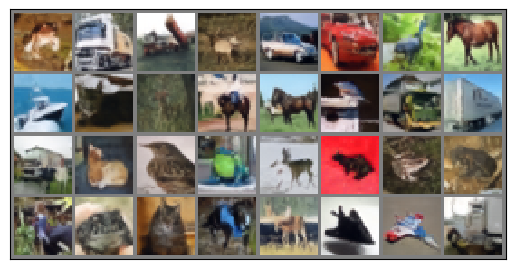

In [10]:
sample = make_grid(valid_reconstructions.cpu().data) + 0.5
sample = torch.clip(sample*255, 0, 255).int()
show(sample)

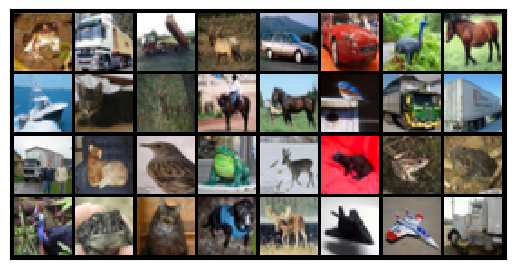

In [11]:
show(make_grid(valid_originals.cpu() + 0.5))

# ImageGPT

In [12]:
from torch.utils.data import Dataset, ConcatDataset
from tqdm.auto import tqdm
from src.transformer_vq_vae.model.encoder import take_indexes


class ImageGPTDataset(Dataset):

    def __init__(self, vq_vae_model, dataset, sos_token):
        super().__init__()

        self.sos_token = sos_token
        self.values = []
        self.targets = []
        self.embeddigns = []

        self.vq_vae_model = vq_vae_model
        self.dataset = dataset

        self._project_dataset(vq_vae_model, dataset)

    def __getitem__(self, item):
        return {'input_ids': self.values[item], "labels": self.targets[item]}
    
    @torch.no_grad()
    def _project_dataset(self, vq_vae_model, dataset):
        dataloader = DataLoader(
            ConcatDataset([dataset]*5),
            batch_size=256,
            shuffle=False,
            num_workers=0
        )
        for batch in tqdm(dataloader):
            x, y, *_ = batch
            x = x.to(device)

            with torch.no_grad():
                # extract pathes featues
                features, backward_indexes = vq_vae_model.encoder(x)
                _, quantized_features, _, input_ids = vq_vae_model.vq_vae(features)
                input_ids = rearrange(input_ids, "(b t) 1 -> t b 1", b=x.shape[0])


                # fill masked pathes with learned embedding
                decoder = vq_vae_model.decoder
                mask_token_id = torch.tensor(
                    config.num_embeddings, 
                    device=vq_vae_model.device
                )[None, None]

                backward_indexes = torch.cat(
                    [
                        torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes),
                        backward_indexes + 1,
                    ],
                    dim=0,
                )
                input_ids = torch.cat(
                    [
                        input_ids,
                        mask_token_id.expand(
                            backward_indexes.shape[0] - input_ids.shape[0], input_ids.shape[1], -1
                        ),
                    ],
                    dim=0,
                )
                input_ids = take_indexes(input_ids, backward_indexes).squeeze()
                input_ids = torch.cat(
                    [
                        torch.full(
                            (1, input_ids.shape[-1]), 
                            self.sos_token, 
                            device=vq_vae_model.device
                        ), 
                        input_ids
                    ],
                    dim=0,
                )
                input_ids = rearrange(input_ids, "t b -> b t")

            self.values.append(input_ids.cpu())
            self.targets.append(y.cpu())

        self.targets = torch.cat(self.targets)

        self.values = torch.cat(self.values)
        self.values = self.values.cpu()
        
    def __len__(self):
        return len(self.values)

In [39]:
vq_vae_model.encoder.mask_ratios = [0.5, 0.6, 0.75]
vq_vae_model.encoder.mask_ratios_probs = [0.4, 0.3, 0.3]
ipgt_training_data = ImageGPTDataset(vq_vae_model, training_data, config.num_embeddings + 1)
ipgt_validation_data = ImageGPTDataset(vq_vae_model, validation_data, config.num_embeddings + 1)

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

In [40]:
@torch.no_grad()
def get_sample_image(
    image_gpt, 
    decoder, 
    embedding,
    device, 
    num_images = 8*4*10,
    return_output = False
):
    image_gpt.eval()
    vq_vae_model.eval()

    with torch.no_grad():
        
        context = torch.full(
            (num_images, 1), 
            1,
            device=device
        )  # initialize with SOS token
        output = image_gpt.generate(
            input_ids=context, 
            max_length=16*16 + 2, 
            temperature=1, 
            do_sample=True, 
            top_k=45,
        )

        output = output[:, 1:]
        # output[output == (config.num_embeddings + 1)] = 0

        quantized = rearrange(embedding(output), "b t c -> t b c")
        features = quantized + decoder.pos_embedding

        features = rearrange(features, "t b c -> b t c")
        features = decoder.transformer(features)
        features = rearrange(features, "b t c -> t b c")
        features = features[1:]  # remove global feature

        patches = decoder.head(features)
        x_recon = decoder.patch2img(patches)
    
    grid_image = make_grid(x_recon.cpu().data, ) 
    grid_image = (grid_image + 0.5)*255
    grid_image = grid_image.clip(0, 255)
    
    if return_output:
        return grid_image, output
    else:
        return grid_image

In [51]:
from transformers import AutoTokenizer, BertForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

inputs = tokenizer("Londin is the [MASK] of Great Britain.", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# retrieve index of [MASK]
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
print(tokenizer.decode(predicted_token_id))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


capital


In [57]:
inputs.input_ids == tokenizer.mask_token_id

tensor[1, 12] bool x∈[False, True] μ=0.083 σ=0.289

In [18]:
from transformers import ImageGPTConfig, AutoImageProcessor
from transformers import ImageGPTForCausalImageModeling

# small_image_gpt = ImageGPTForCausalImageModeling.from_pretrained("openai/imagegpt-small")
configuration = ImageGPTConfig(**{
    "activation_function": "quick_gelu",
    "attn_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "initializer_range": 0.02,
    "layer_norm_epsilon": 1e-05,
    "model_type": "imagegpt",
    "n_embd": config.embedding_dim,
    "n_head": 8,
    "n_layer": 12,
    "n_positions": 16*16+2,
    "reorder_and_upcast_attn": False,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": False,
    "scale_attn_weights": True,
    "tie_word_embeddings": False,
    "use_cache": False,
    "vocab_size": config.num_embeddings + 2}
)
image_gpt = ImageGPTForCausalImageModeling(configuration)
image_gpt.transformer.wte.weight.data[:-2] = vq_vae_model.vq_vae._embedding.weight.data.clone()

image_embeddings = torch.nn.Embedding(config.num_embeddings + 1, config.embedding_dim)
image_embeddings.weight.data[:-1] = vq_vae_model.vq_vae._embedding.weight.data.clone()
image_embeddings.weight.data[-1] = vq_vae_model.decoder.mask_token.data.clone()

counter = 0

In [ ]:
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
from plotly.subplots import make_subplots
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange
import math


def learning_rate_schedule(warmup_steps, total_steps):
    """Linear warmup for warmup_steps, with cosine annealing to 0 at total_steps"""

    def learning_rate_fn(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        else:
            progress = float(step - warmup_steps) / float(
                max(1, total_steps - warmup_steps)
            )
            return 0.5 * (1.0 + math.cos(math.pi * progress))

    return learning_rate_fn

writer = SummaryWriter('logs/lightning_logs/qmae-weight-0.95-decoder-1320-ep')

device = torch.device('cuda:3')
data_loader = DataLoader(
    ipgt_training_data,
    batch_size=32,
    num_workers=4,
    shuffle=True,
)
test_data_loader = DataLoader(
    ipgt_validation_data,
    batch_size=32,
    shuffle=False,
)
optimizer = torch.optim.Adam(image_gpt.parameters(), lr=3e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, learning_rate_schedule(500, len(data_loader))
)

weights = torch.ones(config.num_embeddings + 1)
weights[-1] = 0.95
loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

image_gpt.to(device)
vq_vae_model.to(device)
image_embeddings.to(device)

step = 0
for i in trange(counter, 2):
    counter = i
    writer.add_scalar("epoch", counter, counter)
    
    for batch in tqdm(data_loader):
        step += 1
        
        input_ids = batch["input_ids"].to(device)
        output = image_gpt(input_ids=input_ids)
        loss = loss_fn(
            output.logits[:, :-1].reshape(-1, output.logits.shape[-1]),
            input_ids[..., 1:].reshape(-1)
        )
        loss.backward()
        
        if step % 2 == 0:
            optimizer.step()
            optimizer.zero_grad()

            exp_lr_scheduler.step()        
            
        writer.add_scalar("train/notebook_igpt_loss", loss.cpu().item(), step)
    
        if step % 1000 == 0:
            sample = get_sample_image(
                image_gpt, 
                vq_vae_model.decoder, 
                image_embeddings,
                device, 
            ).cpu() / 255
            writer.add_image('images', sample, step)
            
            model_ckpt_path = (
                f"notebooks/vq_vae_image_gpt/weights/igpt-{step}.ckpt"
            )
            state_dict = image_gpt.state_dict()
            for k, v in state_dict.items():
                state_dict[k] = v.cpu()

            torch.save(state_dict, model_ckpt_path)

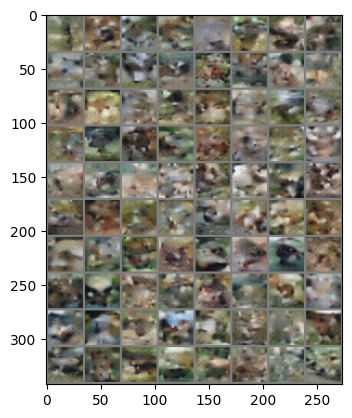

In [20]:
from matplotlib import pyplot as plt 

sample, output = get_sample_image(
    image_gpt, 
    vq_vae_model.decoder, 
    image_embeddings,
    device, 
    8*10,
    return_output = True,
)
sample = sample.cpu() / 255
plt.imshow(sample.permute(1,2,0).numpy())

In [29]:
vq_vae_model.encoder.mask_ratios = [0.5, 0.4, 0.3]
vq_vae_model.encoder.mask_ratios_probs = [0.4, 0.3, 0.3]

ipgt_training_data = ImageGPTDataset(vq_vae_model, training_data, config.num_embeddings + 1)

  0%|          | 0/977 [00:00<?, ?it/s]

In [30]:
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
from plotly.subplots import make_subplots
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange
import math


device = torch.device('cuda:3')
data_loader = DataLoader(
    ipgt_training_data,
    batch_size=32,
    num_workers=4,
    shuffle=True,
)

optimizer = torch.optim.Adam(image_gpt.parameters(), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=len(data_loader),
    eta_min=1e-7,
)

weights = torch.ones(config.num_embeddings + 1)
weights[-1] = 0.95
loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

image_gpt.to(device)
vq_vae_model.to(device)
image_embeddings.to(device)

for i in trange(2):
    writer.add_scalar("epoch", counter, counter)
    
    for batch in tqdm(data_loader):
        step += 1
        
        input_ids = batch["input_ids"].to(device)
        output = image_gpt(input_ids=input_ids)
        loss = loss_fn(
            output.logits[:, :-1].reshape(-1, output.logits.shape[-1]),
            input_ids[..., 1:].reshape(-1)
        )
        loss.backward()
        
        if step % 2 == 0:
            optimizer.step()
            optimizer.zero_grad()

            exp_lr_scheduler.step()        
            
        writer.add_scalar("train/notebook_igpt_loss", loss.cpu().item(), step)
    
        if step % 1000 == 0:
            sample = get_sample_image(
                image_gpt, 
                vq_vae_model.decoder, 
                image_embeddings,
                device, 
            ).cpu() / 255
            writer.add_image('images', sample, step)
            
            model_ckpt_path = (
                f"notebooks/vq_vae_image_gpt/weights/igpt-{step}.ckpt"
            )
            state_dict = image_gpt.state_dict()
            for k, v in state_dict.items():
                state_dict[k] = v.cpu()

            torch.save(state_dict, model_ckpt_path)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7813 [00:00<?, ?it/s]

  0%|          | 0/7813 [00:00<?, ?it/s]

In [62]:
import numpy as np 

from scipy.ndimage import variance
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize


# Resize image
img = sample.permute(1,2,0).numpy()

# Grayscale image
img = rgb2gray(img)

# Edge detection
edge_laplace = laplace(img, ksize=3)

# Print output
print(f"Variance: {variance(edge_laplace)}")
print(f"Maximum : {np.amax(edge_laplace)}")

Variance: 0.013749944942294501
Maximum : 0.920626699924469


In [65]:
import numpy as np 

from scipy.ndimage import variance
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize


# Resize image
img = sample.permute(1,2,0).numpy()

# Grayscale image
img = rgb2gray(img)

# Edge detection
edge_laplace = laplace(img, ksize=3)

# Print output
print(f"Variance: {variance(edge_laplace)}")
print(f"Maximum : {np.amax(edge_laplace)}")

Variance: 0.013727586156514785
Maximum : 0.9119060039520264


# Classification

In [35]:
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import ImageGPTForCausalImageModeling

from src.vq_vae.model.image_gpt_casual import ImageGPTCausal
from src.vq_vae.model.vq_vae import VQVae


class ClassificationDataset(Dataset):
    def __init__(
        self,
        vq_vae_model: VQVae,
        dataset: Dataset,
    ):
        super().__init__()

        self.targets = []
        self.embeddings = []

        self.vq_vae_model = vq_vae_model
        self.dataset = dataset

        self._project_dataset(vq_vae_model, dataset)

    def __getitem__(self, item):
        return {
            "labels": self.targets[item],
            "embeddings": self.embeddings[item],
        }

    def _project_dataset(
        self, vq_vae: VQVae, dataset: Dataset
    ):
        dataloader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=0)
        for batch in tqdm(dataloader, leave=False):
            x, y, *_ = batch
            x = x.to(vq_vae.device)

            with torch.no_grad():
                features, backward_indexes = vq_vae_model.encoder(x, shuffle=False)
                image_emb = features[0]

                self.targets.append(y.cpu())
                self.embeddings.append(image_emb.cpu())

        self.targets = torch.cat(self.targets)
        self.embeddings = torch.cat(self.embeddings)

    def __len__(self):
        return len(self.targets)


In [40]:
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
from plotly.subplots import make_subplots
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange
from src.transformer_vq_vae.model.encoder import take_indexes


writer = cl_strategy.train_logger.experiment

device = torch.device('cuda:3')

clf_model = nn.Linear(config.embedding_dim, 10)
counter = 0
clf_model.to(device)
vq_vae_model.to(device)

# data_loader = DataLoader(
#     ClassificationDataset(vq_vae_model, training_data),
#     batch_size=512,
# )
# test_data_loader = DataLoader(
#     ClassificationDataset(vq_vae_model, validation_data),
#     batch_size=64,
#     shuffle=False,
# )
optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.01)
exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=500,
    eta_min=0.001 * 1e-3,
)


for i in trange(counter, 500):
    counter = i
    writer.add_scalar("epoch", counter, counter)
    
    epoch_losses = []
    epoch_acc = []
    for batch in tqdm(data_loader, leave=False):
        optimizer.zero_grad()
        
        x = batch["embeddings"].to(device)
        y = batch["labels"].to(device)
            
        logits = clf_model(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(-1) == y).float().mean()
        
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.cpu().item())
        epoch_acc.append(acc.cpu().item())
    
    writer.add_scalar("train/clf_loss", np.mean(epoch_losses), i)
    writer.add_scalar("train/clf_acc", np.mean(epoch_acc), i)
    
    if i % 2 ==0:
        epoch_losses = []
        epoch_acc = []
        with torch.no_grad():
            for batch in tqdm(test_data_loader, leave=False):
                x = batch["embeddings"].to(device)
                y = batch["labels"].to(device)

                logits = clf_model(x)
                acc = (logits.argmax(-1) == y).float().mean()
                
                epoch_losses.append(loss.cpu().item())
                epoch_acc.append(acc.cpu().item())
                
        writer.add_scalar("test/clf_loss", np.mean(epoch_losses), i)
        writer.add_scalar("train/clf_acc", np.mean(epoch_acc), i)
        
    
    exp_lr_scheduler.step()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]